In [1]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F 
from torch import nn,optim
import torchvision.models as models
from torchvision import transforms as T,datasets,models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm import tqdm
pd.options.plotting.backend = "plotly"

In [2]:
data_dir = "chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL ='val'

train_dir = os.path.join(data_dir, TRAIN)
test_dir = os.path.join(data_dir, TEST)
val_dir = os.path.join(data_dir, VAL)

print("Train Directory:", train_dir)
print("Test Directory:", test_dir)
print("Validation Directory:", val_dir)

print("Train Directory Exists:", os.path.isdir(train_dir))
print("Test Directory Exists:", os.path.isdir(test_dir))
print("Validation Directory Exists:", os.path.isdir(val_dir))

try:
    trainset = datasets.ImageFolder(train_dir, transform=data_transforms(TRAIN))
    testset = datasets.ImageFolder(test_dir, transform=data_transforms(TEST))
    validset = datasets.ImageFolder(val_dir, transform=data_transforms(VAL))
    print("Datasets loaded successfully!")
except Exception as e:
    print("Error:", e)

Train Directory: chest_xray\train
Test Directory: chest_xray\test
Validation Directory: chest_xray\val
Train Directory Exists: True
Test Directory Exists: True
Validation Directory Exists: True
Error: name 'data_transforms' is not defined


In [3]:
def data_transforms(phase = None):
    
    if phase == TRAIN:

        data_T = T.Compose([
            
                T.Resize(size = (256,256)),
                T.RandomRotation(degrees = (-20,+20)),
                T.CenterCrop(size=224),
                T.ToTensor(),
                T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    
    elif phase == TEST or phase == VAL:

        data_T = T.Compose([

                T.Resize(size = (224,224)),
                T.ToTensor(),
                T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
    return data_T


In [4]:
trainset = datasets.ImageFolder(os.path.join(data_dir, TRAIN),transform = data_transforms(TRAIN))
testset = datasets.ImageFolder(os.path.join(data_dir, TEST),transform = data_transforms(TEST))
validset = datasets.ImageFolder(os.path.join(data_dir, VAL),transform = data_transforms(VAL))

In [5]:
class_names = trainset.classes
print(class_names)
print(trainset.class_to_idx)

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


In [6]:
def plot_class_count(classes,name = None):
    pd.DataFrame(classes,columns = [name]).groupby([classes]).size().plot(kind = 'bar',title = name).show()

In [7]:
def get_class_count(dataset,name = None):
    classes = []
    for _,label in dataset:
        if label == 0:
            classes.append(class_names[label])
            
        elif label == 1:
            classes.append(class_names[label])
            
    return classes

In [8]:
trainset_class_count = get_class_count(trainset,name = 'trainset_classes_count')
plot_class_count(trainset_class_count,name = 'trainset_classes_count')

In [9]:
testset_class_count = get_class_count(testset,name = 'testset_classes_count')
plot_class_count(testset_class_count,name = 'testset_classes_count')

In [10]:
validset_class_count = get_class_count(validset,name = 'validset_classes_count')
plot_class_count(validset_class_count,name = 'validset_classes_count')

In [11]:
trainloader = DataLoader(trainset,batch_size = 16,shuffle = True)
validloader = DataLoader(validset,batch_size = 8,shuffle = True)
testloader = DataLoader(testset,batch_size = 8,shuffle = True)

In [12]:
def show_image(image,title = None,get_denormalize = False):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    if get_denormalize == False:
        plt.figure(figsize=[15, 15])
        plt.imshow(image)

        if title != None:
            plt.title(title)
            
    else : 
        return image

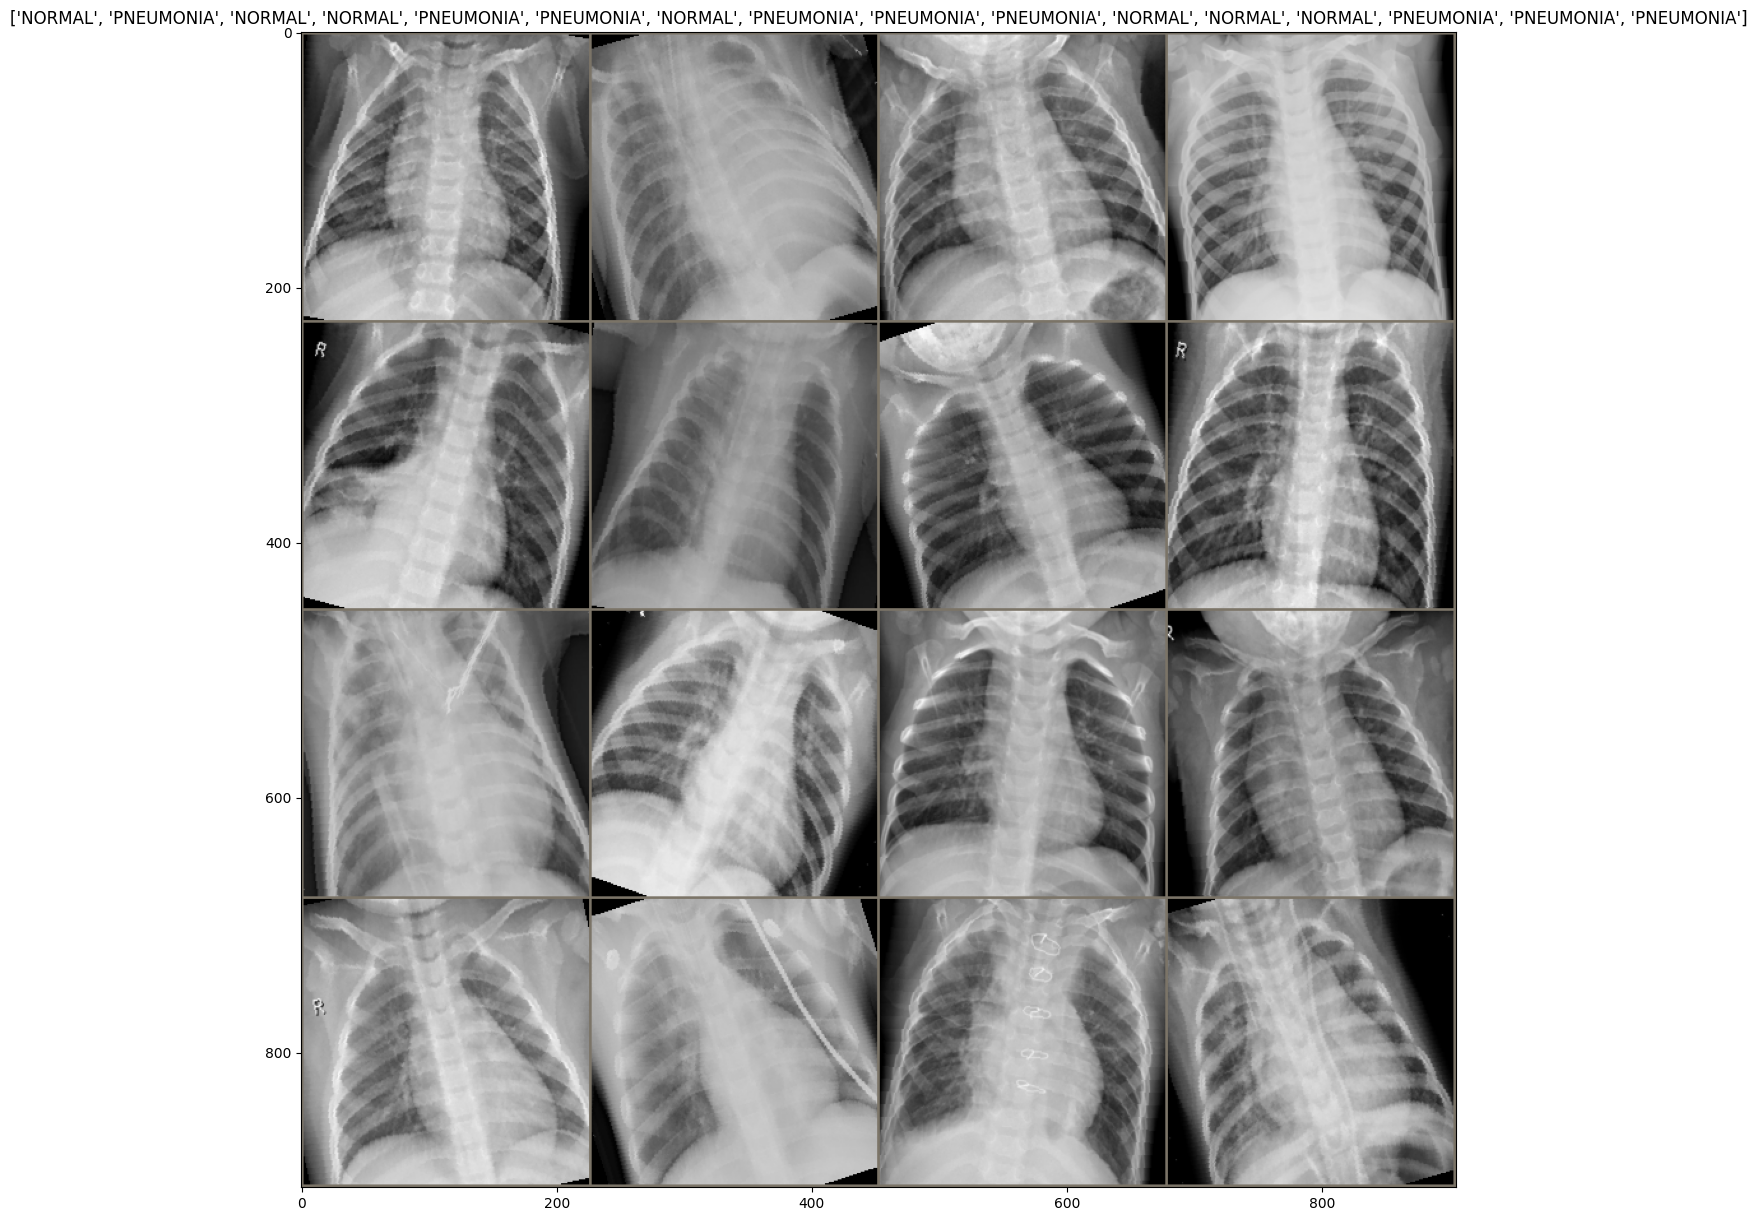

In [13]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

out = make_grid(images, nrow=4)

show_image(out, title=[class_names[x] for x in labels])

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [15]:
model = models.vgg16(pretrained=True)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.



In [16]:
for param in model.parameters():
    param.requires_grad = False




classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 4096)),
                                         ('relu', nn.ReLU()),
                                         ('dropout',nn.Dropout(0.3)),
                                         ('fc2', nn.Linear(4096, 4096)),
                                         ('relu', nn.ReLU()),
                                         ('drop', nn.Dropout(0.3)),
                                         ('fc3', nn.Linear(4096, 2)), 
                                         ('output', nn.LogSoftmax(dim = 1))]))

model.classifier = classifier
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5)
epochs = 3
valid_loss_min = np.Inf

In [18]:
def accuracy(y_pred,y_true):
    y_pred = torch.exp(y_pred)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [19]:
for i in range(epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0 
    
    
    model.train()
    
    for images,labels in tqdm(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        ps = model(images)
        loss = criterion(ps,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += accuracy(ps,labels)
        train_loss += loss.item()
        
    avg_train_acc = train_acc / len(trainloader)
    avg_train_loss = train_loss / len(trainloader)
        
    model.eval()
    with torch.no_grad():
        
        for images,labels in tqdm(validloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            ps = model(images)
            loss = criterion(ps,labels)
            
            valid_acc += accuracy(ps,labels)
            valid_loss += loss.item()
            
            
        avg_valid_acc = valid_acc / len(validloader)
        avg_valid_loss = valid_loss / len(validloader)
        
        schedular.step(avg_valid_loss)
        
        if avg_valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'Pneumonia_model.pt')
            
            valid_loss_min = avg_valid_loss
            
            
    print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1,avg_train_loss,avg_train_acc))
    print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1,avg_valid_loss,avg_valid_acc))

100%|██████████| 2/2 [00:04<00:00,  2.11s/it]


Validation loss decreased (inf --> 0.048644).   Saving model ...
Epoch : 1 Train Loss : 0.496908 Train Acc : 0.923696
Epoch : 1 Valid Loss : 0.048644 Valid Acc : 1.000000


100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


Epoch : 2 Train Loss : 0.291707 Train Acc : 0.937500
Epoch : 2 Valid Loss : 0.165576 Valid Acc : 0.937500


100%|██████████| 2/2 [00:03<00:00,  1.76s/it]

Epoch : 3 Train Loss : 0.177912 Train Acc : 0.952837
Epoch : 3 Valid Loss : 0.194205 Valid Acc : 0.937500


In [20]:
model.eval()

test_loss = 0
test_acc = 0

for images,labels in testloader:
    
    images = images.to(device)
    labels = labels.to(device)
    
    pred = model(images)
    loss = criterion(pred,labels)
    
    test_loss += loss.item()
    test_acc += accuracy(pred,labels)
    
avg_test_loss = test_loss/len(testloader)
avg_test_acc = test_acc/len(testloader)

print("Test Loss : {:.6f} Test Acc : {:.6f}".format(avg_test_loss,avg_test_acc))

Test Loss : 0.704729 Test Acc : 0.850962


In [21]:
def view_classify(img,ps,label):
    
    class_name = ['NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    img = show_image(img,get_denormalize = True)
    
    

    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

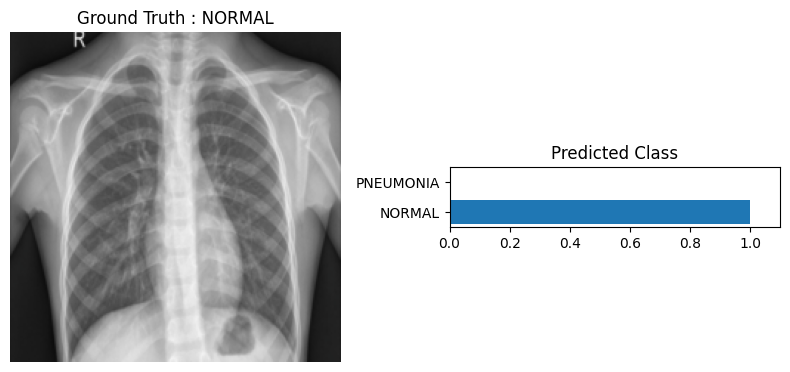

In [22]:
image,label = testset[0]

ps = torch.exp(model(image.to(device).unsqueeze(0)))
view_classify(image,ps,label)

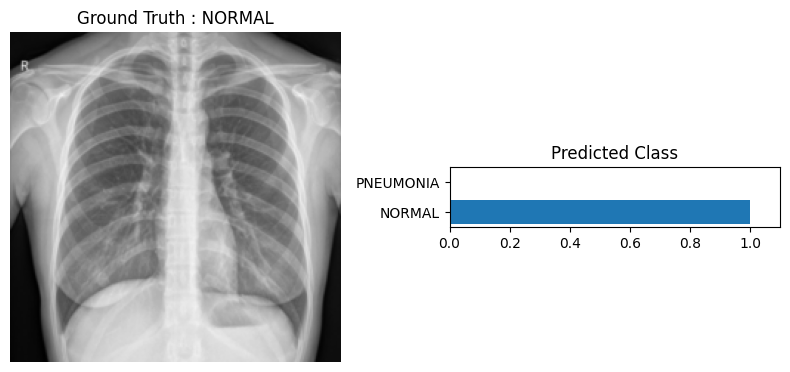

In [25]:
image,label = testset[33]

ps = torch.exp(model(image.to(device).unsqueeze(0)))
view_classify(image,ps,label)

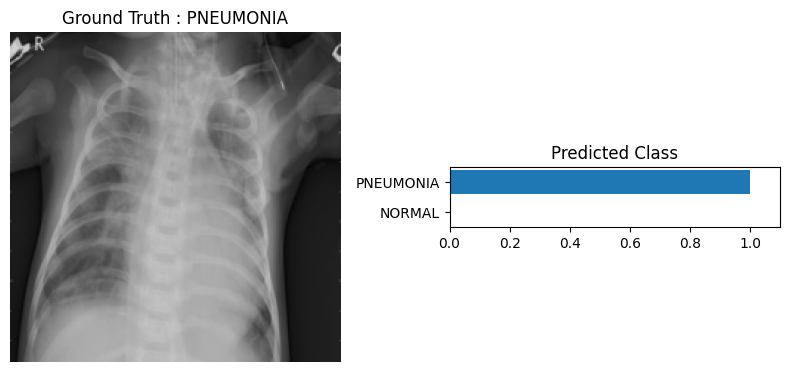

In [24]:
image,label = testset[330]

ps = torch.exp(model(image.to(device).unsqueeze(0)))
view_classify(image,ps,label)

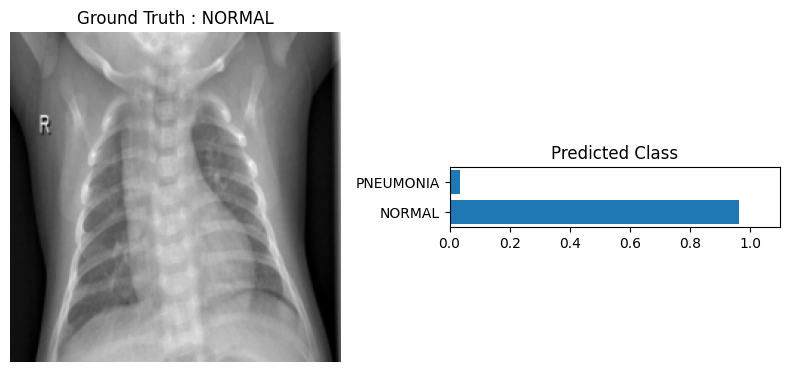

In [26]:
image,label = testset[49]

ps = torch.exp(model(image.to(device).unsqueeze(0)))
view_classify(image,ps,label)

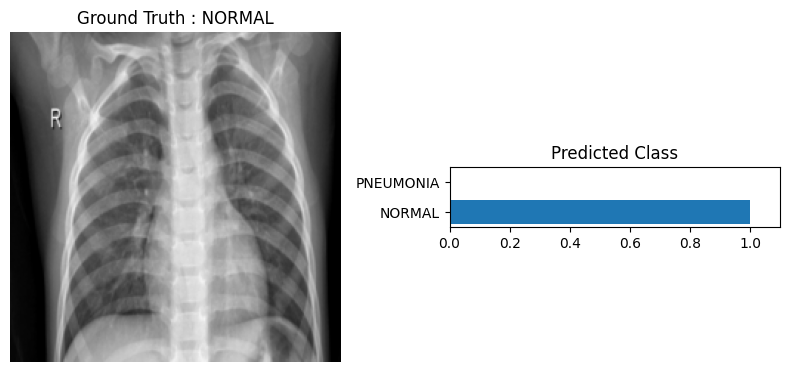

In [27]:
image,label = testset[56]

ps = torch.exp(model(image.to(device).unsqueeze(0)))
view_classify(image,ps,label)